<a href="https://colab.research.google.com/github/Heo-JuYeong/Data_Analysis_Team3_Project/blob/main/Fine_Tunning_Unet_3000_success.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **기본 설정**

In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install segmentation-models-pytorch
!pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unin

In [3]:
# 라이브러리 import
import os
import cv2

import numpy as np

import segmentation_models_pytorch as smp
import torch

from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, optim
from torchvision.transforms import ToTensor
from torchvision import transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# **새 섹션**

## Define . . .

In [5]:
# 정답 데이터(label)와 class mapping

GRAYSCALE_CLASS_MAP = {
    10: 0, 20: 1, 30: 2, 40: 3,
    50: 4, 60: 5, 70: 6, 80: 7, 100: 8
}

def convert_mask(mask):
    converted = np.zeros_like(mask, dtype=np.uint8)
    for gray_val, class_idx in GRAYSCALE_CLASS_MAP.items():
        converted[mask == gray_val] = class_idx
    return converted

In [6]:
# 사용자 정의 Dataset 클래스

class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = convert_mask(mask)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.long()

In [7]:
# EarlyStopping 클래스

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} / {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [8]:
# transform 정의

train_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(),
    ToTensorV2()
])

## 경로 설정 및 dataset 분할

In [9]:
# train & validation set

image_dir = '/content/drive/Shareddrives/Landcover_15000/images/train'
mask_dir = '/content/drive/Shareddrives/Landcover_15000/masks/train'
image_paths = sorted(glob(os.path.join(image_dir, '*.tif')))
mask_paths = sorted(glob(os.path.join(mask_dir, '*.tif')))

full_dataset = SegmentationDataset(image_paths, mask_paths, transform=train_transform)
full_dataloader = DataLoader(full_dataset, batch_size=10, shuffle=True)

In [10]:
# train/validation/test split
# 20000장 다 돌리기엔 무리가 있어서 4000장만 랜덤 추출/ train 3000 / val 500 / test 500


to_use = 4000
use_dataset, trash_dataset = random_split(full_dataset, [4000, len(full_dataset)-to_use])
print(len(use_dataset))

train_dataset_, test_dataset = random_split(use_dataset, [3500, 500])
train_dataset, val_dataset = random_split(train_dataset_, [3000, 500])

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

4000


In [11]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

3000
500
500


# **모델 불러오기&학습**

In [12]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=9
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [13]:
# EarlyStopping & ModelCheckpoint

best_val_loss = float('inf')
patience = 5

trigger_times = 0
save_path = '/content/drive/Shareddrives/Landcover_15000/best_unet_model_3000.pth'
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)

    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(train_loss=loss.item())

    epoch_loss = running_loss / len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)

            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_masks).item()

    val_loss /= len(val_loader)
    print(f"\nEpoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    # EarlyStopping & Checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print(f"Validation loss improved. Saving model to {save_path}")
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"No improvement in validation loss for {trigger_times} epochs.")

    if trigger_times >= patience:
        print("Early stopping triggered. Training stopped.")
        break


Epoch 1, Train Loss: 1.0400, Val Loss: 0.5819
Validation loss improved. Saving model to /content/drive/Shareddrives/Landcover_15000/best_unet_model_3000.pth



Epoch 2, Train Loss: 0.5514, Val Loss: 0.4423
Validation loss improved. Saving model to /content/drive/Shareddrives/Landcover_15000/best_unet_model_3000.pth



Epoch 3, Train Loss: 0.4213, Val Loss: 0.3726
Validation loss improved. Saving model to /content/drive/Shareddrives/Landcover_15000/best_unet_model_3000.pth



Epoch 4, Train Loss: 0.3619, Val Loss: 0.3317
Validation loss improved. Saving model to /content/drive/Shareddrives/Landcover_15000/best_unet_model_3000.pth



Epoch 5, Train Loss: 0.3119, Val Loss: 0.3890
No improvement in validation loss for 1 epochs.



Epoch 6, Train Loss: 0.2817, Val Loss: 0.3105
Validation loss improved. Saving model to /content/drive/Shareddrives/Landcover_15000/best_unet_model_3000.pth



Epoch 7, Train Loss: 0.2545, Val Loss: 0.3030
Validation loss improved. Saving model to /content/drive/Shareddrives/Landcover_15000/best_unet_model_3000.pth



Epoch 8, Train Loss: 0.2317, Val Loss: 0.3208
No improvement in validation loss for 1 epochs.



Epoch 9, Train Loss: 0.2221, Val Loss: 0.5225
No improvement in validation loss for 2 epochs.



Epoch 10, Train Loss: 0.2001, Val Loss: 0.2794
Validation loss improved. Saving model to /content/drive/Shareddrives/Landcover_15000/best_unet_model_3000.pth



Epoch 11, Train Loss: 0.1748, Val Loss: 0.2860
No improvement in validation loss for 1 epochs.



Epoch 12, Train Loss: 0.1730, Val Loss: 0.2847
No improvement in validation loss for 2 epochs.



Epoch 13, Train Loss: 0.1691, Val Loss: 0.3011
No improvement in validation loss for 3 epochs.



Epoch 14, Train Loss: 0.1538, Val Loss: 0.2794
No improvement in validation loss for 4 epochs.



Epoch 15, Train Loss: 0.1485, Val Loss: 0.2944
No improvement in validation loss for 5 epochs.
Early stopping triggered. Training stopped.


# **평가 및 시각화**

## metric 계산 함수 정의

In [14]:
# Intersection over Union (IoU)

def compute_iou(pred, target, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()
        if union == 0:
            ious.append(float('nan'))  # 해당 클래스가 없을 때
        else:
            ious.append(float(intersection) / float(union))
    return np.nanmean(ious)  # 평균 IoU

In [15]:
# Dice Coeifficient

def dice_coefficient(pred, target, num_classes):
    dices = []
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum()
        dice = (2. * intersection) / (pred_inds.sum() + target_inds.sum() + 1e-7)
        dices.append(dice)
    return np.mean(dices)

In [16]:
# Pixel Accuracy

def pixel_accuracy(pred, target):
    correct = (pred == target).sum()
    total = pred.size
    return correct / total

## 평가 및 시각화

In [17]:
# 모델 평가

model.eval()

ious = []
dices = []
pixel_accs = []

for i in tqdm(range(len(test_dataset)), desc="Evaluating"):
    sample_img, sample_mask = test_dataset[i]
    sample_img_cuda = sample_img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(sample_img_cuda)
        pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()

    gt_mask = sample_mask.cpu().numpy()

    # metric 계산
    iou = compute_iou(pred_mask, gt_mask, num_classes=9)
    dice = dice_coefficient(pred_mask, gt_mask, num_classes=9)
    pixel_acc = pixel_accuracy(pred_mask, gt_mask)

    ious.append(iou)
    dices.append(dice)
    pixel_accs.append(pixel_acc)


# 전체 평균 결과 출력
print(f"\n📊 Evaluation Result")
print(f"Mean IoU: {sum(ious)/len(ious):.4f}")
print(f"Mean Dice: {sum(dices)/len(dices):.4f}")
print(f"Mean Pixel Accuracy: {sum(pixel_accs)/len(pixel_accs):.4f}")

Evaluating: 100%|██████████| 500/500 [21:33<00:00,  2.59s/it]


📊 Evaluation Result
Mean IoU: 0.5993
Mean Dice: 0.3697
Mean Pixel Accuracy: 0.8983


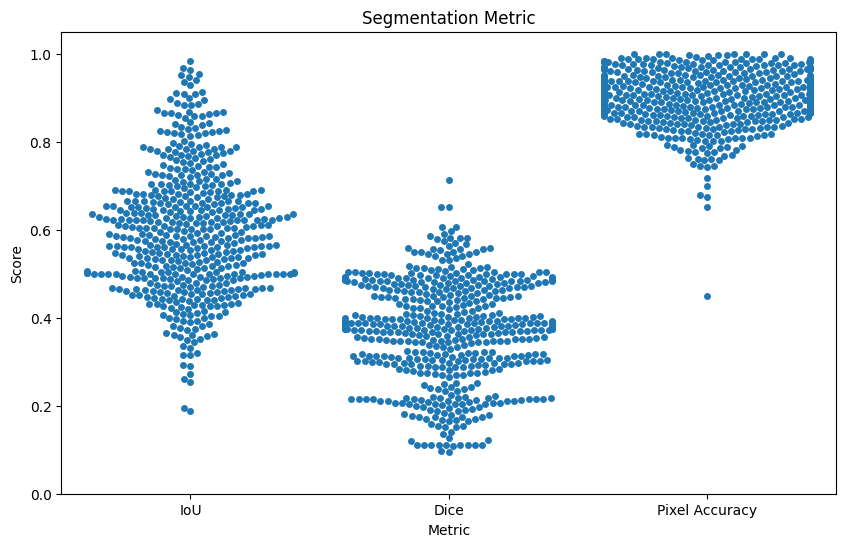

In [19]:
import pandas as pd

df = pd.DataFrame({
    "IoU": ious,
    "Dice": dices,
    "Pixel Accuracy": pixel_accs
})
df_long = df.melt(var_name="Metric", value_name="Score")

# Swarmplot
plt.figure(figsize=(10, 6))
sns.swarmplot(data=df_long, x="Metric", y="Score", size=5)
plt.title("Segmentation Metric")
plt.ylim(0, 1.05)
plt.show()

In [20]:
# 9개 클래스에 대해 고정된 colormap

CLASS_COLORS = np.array([
    [0, 0, 255],     # 건물 (blue)
    [128, 0, 128],   # 주차장 (purple)
    [0, 255, 255],   # 도로 (cyan)
    [0, 255, 0],     # 가로수 (green)
    [255, 255, 0],   # 논 (yellow)
    [255, 200, 0],   # 밭 (orange)
    [0, 128, 0],     # 산림 (dark green)
    [139, 69, 19],   # 나지 (brown)
    [128, 128, 128], # 비대상지 (gray)
], dtype=np.uint8)

def decode_segmap(mask):
    """Class index mask -> RGB image"""
    return CLASS_COLORS[mask]

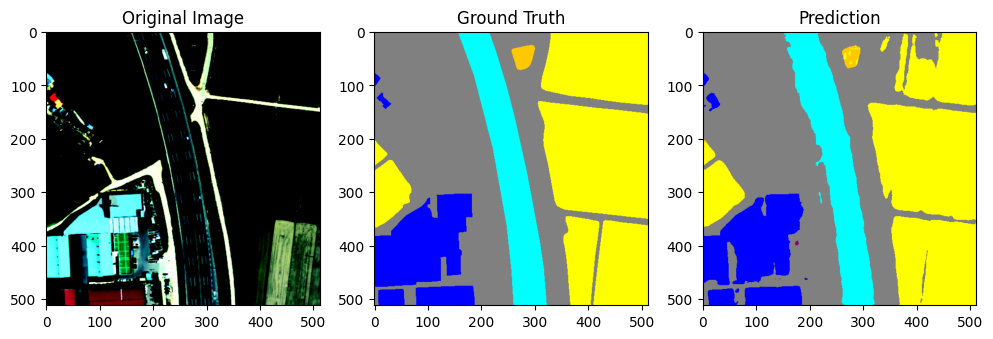

In [23]:
# 시각화

with torch.no_grad():
    sample_img, sample_mask = test_dataset[6]
    sample_img_cuda = sample_img.unsqueeze(0).to(device)

    pred = model(sample_img_cuda)
    pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()  # [C,H,W] -> [H,W]
    gt_mask = sample_mask.cpu().numpy()

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(sample_img.permute(1,2,0).cpu().numpy())
    plt.title("Original Image")

    plt.subplot(1,3,2)
    plt.imshow(decode_segmap(gt_mask))
    plt.title("Ground Truth")

    plt.subplot(1,3,3)
    plt.imshow(decode_segmap(pred_mask))
    plt.title("Prediction")

    plt.show()